# Advanced NER Model Evaluation

This notebook provides a detailed evaluation of NER models (CyNER and SecureBERT) on the DNRTI dataset. 

**Key Features:**
1. **Config-Aware Evaluation**: Models are only evaluated on the labels they are trained to recognize (defined in their `config.json`). Ground truth labels outside the model's scope are ignored to prevent unfair False Negatives.
2. **Mapped Evaluation**: Model-specific labels are mapped to DNRTI dataset labels for consistent comparison.
3. **BIO Tag Analysis**: Detailed breakdown of B- (Beginning) and I- (Inside) tag performance.
4. **Unique Entity Evaluation**: Performance metrics based on the set of unique entities identified, not just token-level or instance-level matches.
5. **Visualizations**: Comprehensive plots for metrics and confusion matrices.

## Metric Explanations

Before running the evaluation, here is what each metric represents:

### 1. Standard Metrics (Token/Span Level)
- **Latency (sec/doc)**: The average time it takes for the model to process a single document (sentence). Lower is better for real-time applications.
- **Precision**: The accuracy of the positive predictions. `TP / (TP + FP)`. High precision means the model rarely hallucinates entities (few False Positives).
- **Recall**: The ability of the model to find all positive instances. `TP / (TP + FN)`. High recall means the model rarely misses real entities (few False Negatives).
- **F1-Score**: The harmonic mean of Precision and Recall. Provides a single score that balances both concerns.

### 2. Unique Entity Metrics
- **Unique Entity F1**: Evaluates the model based on the *set* of unique entities found in a document, ignoring duplicates. 
  - *Example*: If "WannaCry" appears 5 times in a text and the model finds it once, it counts as a success for Unique Entity Recall. This is useful for tasks like Knowledge Graph population where you just need to know *if* an entity exists in the text.

### 3. BIO Tag Statistics
- **B- (Beginning)**: Marks the start of an entity.
- **I- (Inside)**: Marks the continuation of an entity.
- **O (Outside)**: Marks non-entity tokens.
- **BIO Error Analysis**: We check specifically for:
  - **False Positive**: Model predicted an entity where there was none (O -> B/I).
  - **False Negative**: Model missed an entity (B/I -> O).
  - **Wrong Label**: Model found an entity boundary correctly but assigned the wrong class (e.g., Org -> Tool).

In [ ]:
!pip install transformers torch pandas scikit-learn seqeval seaborn matplotlib numpy

In [9]:
import os
import json
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import torch

# Set device
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {device}")

Using device: -1


## 1. Load Data & Configure Mappings

In [10]:
DATA_DIR = "../DNRTI"

def load_dnrti_file(file_path):
    data = []
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found.")
        return data
        
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        tokens = []
        labels = []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    data.append({'tokens': tokens, 'labels': labels})
                    tokens = []
                    labels = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    tokens.append(parts[0])
                    labels.append(parts[-1])
        if tokens:
             data.append({'tokens': tokens, 'labels': labels})
    return data

# Load Data
full_data = []
for filename in ['train.txt', 'test.txt', 'valid.txt']:
    full_data.extend(load_dnrti_file(os.path.join(DATA_DIR, filename)))

print(f"Total sentences loaded: {len(full_data)}")

# Split Data (Use same split logic as before: 90% Test, 10% Valid)
texts = [d['tokens'] for d in full_data]
labels = [d['labels'] for d in full_data]

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

# We will use the validation set for evaluation
EVAL_TEXTS = val_texts
EVAL_LABELS = val_labels
print(f"Evaluation set size: {len(EVAL_TEXTS)}")

Total sentences loaded: 6577
Evaluation set size: 658


In [11]:
# --- MAPPINGS ---
# Maps Model Entity Groups -> DNRTI Label Categories

LABEL_MAP = {
    # SecureBERT mappings
    "APT": "HackOrg",
    "MAL": "Tool",        
    "TOOL": "Tool",
    "LOC": "Area",
    "TIME": "Time",
    "SECTEAM": "SecTeam", 
    "IDTY": "Idus",
    "ACT": "OffAct",      
    "VULNAME": "Way",
    "VULID": "Way",
    "OS": "Tool",
    "FILE": "SamFile",    
    "ENCR": "Tool",
    "PROT": "Tool",
    "DOM": "Tool",
    "URL": "Tool",
    "IP": "Tool",
    "SHA2": "Tool",
    "SHA1": "Tool",
    "MD5": "Tool",
    "EMAIL": "Org",

    # CyNER mappings
    "Malware": "Tool",
    "Organization": "Org",
    "System": "Tool",
    "Indicator": "Tool",
    "Vulnerability": "Way",
}

def map_entity(entity_group):
    return LABEL_MAP.get(entity_group, entity_group)

## 2. Model Loading & Config Parsing

In [12]:
MODELS_CONFIG = {
    "CyNER": "../NER/CyNER",
    "SecureBERT": "../NER/SecureBert-NER"
}

loaded_pipelines = {}
model_supported_labels = {}

for name, path in MODELS_CONFIG.items():
    if os.path.exists(path):
        print(f"Loading {name} from {path}...")
        tokenizer = AutoTokenizer.from_pretrained(path)
        model = AutoModelForTokenClassification.from_pretrained(path)
        
        # Extract supported labels from config
        config = model.config
        id2label = config.id2label
        labels = set(id2label.values())
        
        # Clean labels (remove B-/I- prefixes to get raw types)
        raw_types = set()
        for l in labels:
            if l == 'O': continue
            if l.startswith('B-') or l.startswith('I-'):
                raw_types.add(l[2:])
            else:
                raw_types.add(l)
        
        # Determine which DNRTI labels this model can theoretically predict based on the map
        supported_dnrti_labels = set()
        for raw in raw_types:
            mapped = map_entity(raw)
            supported_dnrti_labels.add(mapped)
            
        model_supported_labels[name] = supported_dnrti_labels
        print(f"  Supported Model Entities: {sorted(list(raw_types))}")
        print(f"  Mapped DNRTI Labels:    {sorted(list(supported_dnrti_labels))}")
        
        loaded_pipelines[name] = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)
    else:
        print(f"Error: Path {path} does not exist.")

Loading CyNER from NER/CyNER...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1553.75it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


  Supported Model Entities: ['Indicator', 'Malware', 'Organization', 'System', 'Vulnerability']
  Mapped DNRTI Labels:    ['Org', 'Tool', 'Way']
Loading SecureBERT from NER/SecureBert-NER...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1216.31it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              

  Supported Model Entities: ['ACT', 'APT', 'DOM', 'EMAIL', 'ENCR', 'FILE', 'IDTY', 'IP', 'LOC', 'MAL', 'MD5', 'OS', 'PROT', 'SECTEAM', 'SHA1', 'SHA2', 'TIME', 'TOOL', 'URL', 'VULID', 'VULNAME']
  Mapped DNRTI Labels:    ['Area', 'HackOrg', 'Idus', 'OffAct', 'Org', 'SamFile', 'SecTeam', 'Time', 'Tool', 'Way']


## 3. Evaluation Logic

We implement a custom evaluation loop that:
1. Aligns predictions to tokens.
2. Filters Ground Truth: Any label in Ground Truth that is NOT in `model_supported_labels` is converted to `O`.
3. Calculates strict metrics.
4. Captures example cases.

In [13]:
def align_predictions(predictions, token_list, label_map):
    """
    Aligns pipeline predictions to original tokens and applies mapping.
    """
    aligned_labels = ['O'] * len(token_list)
    
    # Create character spans for tokens
    token_spans = []
    current_char = 0
    for token in token_list:
        start = current_char
        end = start + len(token)
        token_spans.append((start, end))
        current_char = end + 1 # +1 for space
        
    for pred in predictions:
        p_start = pred['start']
        p_end = pred['end']
        entity_group = pred['entity_group']
        mapped_label = label_map.get(entity_group, entity_group)
        
        for idx, (t_start, t_end) in enumerate(token_spans):
            # Check overlap
            if max(t_start, p_start) < min(t_end, p_end):
                # Determine B- or I-
                prefix = "B-"
                # If previous token was same entity, use I-
                if idx > 0 and aligned_labels[idx-1] != 'O':
                    prev_label = aligned_labels[idx-1]
                    if prev_label.endswith(mapped_label):
                         prefix = "I-"
                
                # Force B- if it's the very start of the prediction span overlap (approximate)
                if t_start <= p_start:
                     prefix = "B-"
                
                aligned_labels[idx] = f"{prefix}{mapped_label}"
                
    return aligned_labels

def filter_ground_truth(labels, supported_types):
    """
    Converts labels not supported by the model to 'O'.
    """
    filtered = []
    for l in labels:
        if l == 'O':
            filtered.append('O')
        else:
            # Extract type
            type_ = l[2:]
            if type_ in supported_types:
                filtered.append(l)
            else:
                filtered.append('O')
    return filtered

def extract_unique_entities(tokens, labels):
    """
    Extracts set of (Entity Text, Entity Type) tuples.
    """
    entities = set()
    current_entity = []
    current_type = None
    
    for token, label in zip(tokens, labels):
        if label.startswith("B-"):
            if current_entity:
                entities.add((" ".join(current_entity), current_type))
            current_entity = [token]
            current_type = label[2:]
        elif label.startswith("I-") and current_type == label[2:]:
            current_entity.append(token)
        else:
            if current_entity:
                entities.add((" ".join(current_entity), current_type))
            current_entity = []
            current_type = None
            
    if current_entity:
        entities.add((" ".join(current_entity), current_type))
        
    return entities

In [14]:
results = {}

print("Starting Evaluation...")

for model_name, pipe in loaded_pipelines.items():
    print(f"\nEvaluated Model: {model_name}")
    supported_types = model_supported_labels[model_name]
    
    all_preds = []
    all_trues_filtered = []
    
    # Examples storage
    examples = {
        'success': [],
        'failure': []
    }
    
    # For Unique Entity Stats
    unique_true_positives = 0
    unique_false_positives = 0
    unique_false_negatives = 0
    
    # For BIO Stats
    bio_stats = Counter()
    
    start_time = time.time()
    
    for i, tokens in enumerate(EVAL_TEXTS):
        text_str = " ".join(tokens)
        orig_labels = EVAL_LABELS[i]
        
        # 1. Predict
        try:
            preds = pipe(text_str)
        except Exception as e:
            preds = []
            
        # 2. Align & Map
        pred_labels = align_predictions(preds, tokens, LABEL_MAP)
        
        # 3. Filter Ground Truth (Ignore unsupported types)
        true_labels_filtered = filter_ground_truth(orig_labels, supported_types)
        
        all_preds.append(pred_labels)
        all_trues_filtered.append(true_labels_filtered)
        
        # 4. Unique Entity Logic
        true_entities = extract_unique_entities(tokens, true_labels_filtered)
        pred_entities = extract_unique_entities(tokens, pred_labels)
        
        unique_true_positives += len(true_entities.intersection(pred_entities))
        unique_false_positives += len(pred_entities - true_entities)
        unique_false_negatives += len(true_entities - pred_entities)
        
        # 5. BIO Stats
        for p, t in zip(pred_labels, true_labels_filtered):
            if p == t:
                bio_stats["Correct"] += 1
            else:
                if t == 'O' and p != 'O': bio_stats["False Positive"] += 1
                elif t != 'O' and p == 'O': bio_stats["False Negative"] += 1
                elif t != p: bio_stats["Wrong Label"] += 1
        
        # 6. Capture Examples
        # Success: Exact match on labels (and at least one entity present)
        if len(examples['success']) < 3:
            if pred_labels == true_labels_filtered and any(l != 'O' for l in true_labels_filtered):
                examples['success'].append((tokens, true_labels_filtered, pred_labels))
        
        # Failure: Mismatch
        if len(examples['failure']) < 3:
            if pred_labels != true_labels_filtered:
                examples['failure'].append((tokens, true_labels_filtered, pred_labels))

    duration = time.time() - start_time
    latency_per_doc = duration / len(EVAL_TEXTS)
    
    # Metrics Calculation
    report = classification_report(all_trues_filtered, all_preds, output_dict=True, zero_division=0)
    
    # Unique Entity Metrics
    uniq_prec = unique_true_positives / (unique_true_positives + unique_false_positives) if (unique_true_positives + unique_false_positives) > 0 else 0
    uniq_rec = unique_true_positives / (unique_true_positives + unique_false_negatives) if (unique_true_positives + unique_false_negatives) > 0 else 0
    uniq_f1 = 2 * (uniq_prec * uniq_rec) / (uniq_prec + uniq_rec) if (uniq_prec + uniq_rec) > 0 else 0
    
    results[model_name] = {
        "report": report,
        "unique_metrics": {
            "precision": uniq_prec,
            "recall": uniq_rec,
            "f1": uniq_f1,
            "counts": (unique_true_positives, unique_false_positives, unique_false_negatives)
        },
        "bio_stats": bio_stats,
        "duration": duration,
        "latency": latency_per_doc,
        "examples": examples
    }
    
    print(f"  Latency: {latency_per_doc:.4f} sec/doc")
    print(f"  F1 (Token-based):     {report['macro avg']['f1-score']:.4f}")
    print(f"  F1 (Unique Entities): {uniq_f1:.4f}")

Starting Evaluation...

Evaluated Model: CyNER
  Latency: 0.0451 sec/doc
  F1 (Token-based):     0.1084
  F1 (Unique Entities): 0.1694

Evaluated Model: SecureBERT
  Latency: 0.0479 sec/doc
  F1 (Token-based):     0.5910
  F1 (Unique Entities): 0.6606


## 4. Visualizations & Reporting

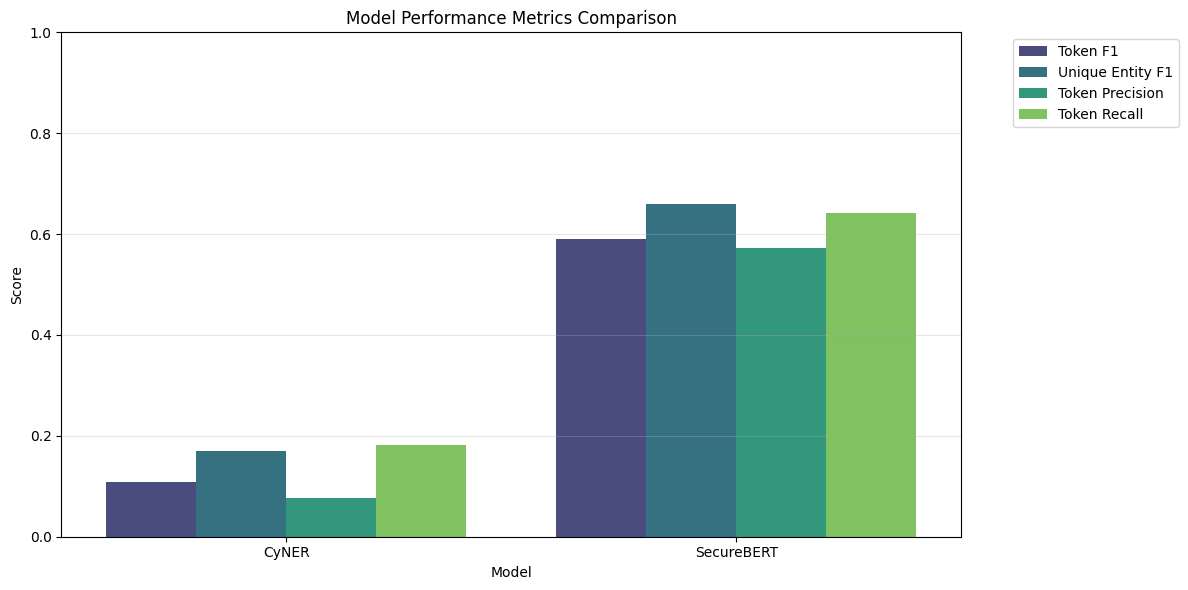

/var/folders/b2/r64p6kv15n33cd11gh4qf74m0000gn/T/ipykernel_62644/1822261913.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_latency, x="Model", y="Latency (s/doc)", palette="magma")


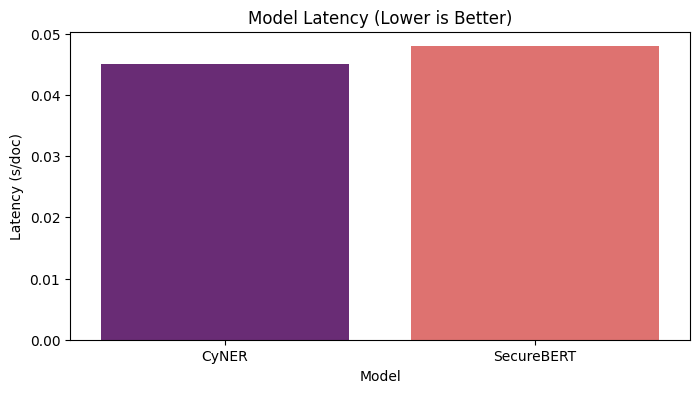

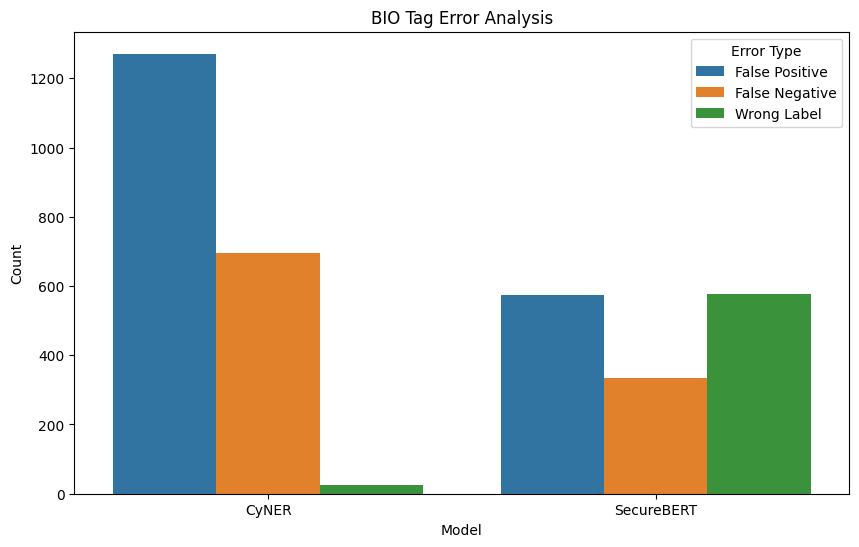


MODEL: CyNER
Latency: 0.0451 sec/doc
Standard Precision: 0.0771
Standard Recall:    0.1825
Standard F1:        0.1084

--- Token Classification Report ---
              precision    recall  f1-score  support
Org            0.067340  0.151515  0.093240    132.0
Tool           0.163978  0.396104  0.231939    308.0
Way            0.000000  0.000000  0.000000    115.0
micro avg      0.123586  0.255856  0.166667    555.0
macro avg      0.077106  0.182540  0.108393    555.0
weighted avg   0.107017  0.255856  0.150892    555.0

--- Unique Entity Stats ---
  Precision: 0.1260
  Recall:    0.2582
  F1:        0.1694
  TP: 142, FP: 985, FN: 408

MODEL: SecureBERT
Latency: 0.0479 sec/doc
Standard Precision: 0.5725
Standard Recall:    0.6411
Standard F1:        0.5910

--- Token Classification Report ---
              precision    recall  f1-score  support
Area           0.901887  0.885185  0.893458    270.0
HackOrg        0.930362  0.742222  0.825711    450.0
Idus           0.418462  0.912752  0

In [15]:
# 1. Model Comparison Bar Chart (Standard vs Unique F1)
metrics_df = []
for name, res in results.items():
    metrics_df.append({
        "Model": name,
        "Score": res['report']['macro avg']['f1-score'],
        "Metric": "Token F1"
    })
    metrics_df.append({
        "Model": name,
        "Score": res['unique_metrics']['f1'],
        "Metric": "Unique Entity F1"
    })
    metrics_df.append({
        "Model": name,
        "Score": res['report']['macro avg']['precision'],
        "Metric": "Token Precision"
    })
    metrics_df.append({
        "Model": name,
        "Score": res['report']['macro avg']['recall'],
        "Metric": "Token Recall"
    })

df_metrics = pd.DataFrame(metrics_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_metrics, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Performance Metrics Comparison")
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Latency Comparison
latencies = [{'Model': name, 'Latency (s/doc)': res['latency']} for name, res in results.items()]
df_latency = pd.DataFrame(latencies)

plt.figure(figsize=(8, 4))
sns.barplot(data=df_latency, x="Model", y="Latency (s/doc)", palette="magma")
plt.title("Model Latency (Lower is Better)")
plt.show()

# 3. BIO Tag Statistics
bio_data = []
for name, res in results.items():
    stats = res['bio_stats']
    total = sum(stats.values())
    for k, v in stats.items():
        # Exclude correct for error analysis view
        if k != 'Correct':
            bio_data.append({
                "Model": name,
                "Error Type": k,
                "Count": v
            })

df_bio = pd.DataFrame(bio_data)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_bio, x="Model", y="Count", hue="Error Type")
plt.title("BIO Tag Error Analysis")
plt.show()

# 4. Detailed Text Report
for name, res in results.items():
    print(f"\n{'='*20}\nMODEL: {name}\n{'='*20}")
    print(f"Latency: {res['latency']:.4f} sec/doc")
    print(f"Standard Precision: {res['report']['macro avg']['precision']:.4f}")
    print(f"Standard Recall:    {res['report']['macro avg']['recall']:.4f}")
    print(f"Standard F1:        {res['report']['macro avg']['f1-score']:.4f}")
    
    print("\n--- Token Classification Report ---")
    print(pd.DataFrame(res['report']).transpose().to_string())
    
    print("\n--- Unique Entity Stats ---")
    u = res['unique_metrics']
    print(f"  Precision: {u['precision']:.4f}")
    print(f"  Recall:    {u['recall']:.4f}")
    print(f"  F1:        {u['f1']:.4f}")
    print(f"  TP: {u['counts'][0]}, FP: {u['counts'][1]}, FN: {u['counts'][2]}")

## 5. Example Predictions

Below are examples of where the models succeeded and failed.

In [17]:
def print_example(tokens, true_labels, pred_labels):
    # Print token | True | Pred for non-O tokens
    print(f"{'Token':<20} | {'True Label':<15} | {'Predicted':<15}")
    print("-" * 55)
    has_entity = False
    for t, tr, pr in zip(tokens, true_labels, pred_labels):
        if tr != 'O' or pr != 'O':
            print(f"{t:<20} | {tr:<15} | {pr:<15}")
            has_entity = True
    if not has_entity:
        print("(No entities in sentence)")
    print("\n")

for name, res in results.items():
    print(f"\n{'#'*30}\nEXAMPLES FOR {name}\n{'#'*30}")
    
    print("\n--- SUCCESS EXAMPLES (Top 3) ---")
    for i, (tokens, true_l, pred_l) in enumerate(res['examples']['success']):
        print(f"Example {i+1}:")
        print_example(tokens, true_l, pred_l)
        
    print("\n--- FAILURE EXAMPLES (Top 3) ---")
    for i, (tokens, true_l, pred_l) in enumerate(res['examples']['failure']):
        print(f"Example {i+1}:")
        print_example(tokens, true_l, pred_l)


##############################
EXAMPLES FOR CyNER
##############################

--- SUCCESS EXAMPLES (Top 3) ---
Example 1:
Token                | True Label      | Predicted      
-------------------------------------------------------
Slingshot            | B-Tool          | B-Tool         


Example 2:
Token                | True Label      | Predicted      
-------------------------------------------------------
Samas                | B-Tool          | B-Tool         
BitPaymer            | B-Tool          | B-Tool         
Ryuk                 | B-Tool          | B-Tool         


Example 3:
Token                | True Label      | Predicted      
-------------------------------------------------------
Emotet               | B-Tool          | B-Tool         
Emotet               | B-Tool          | B-Tool         



--- FAILURE EXAMPLES (Top 3) ---
Example 1:
Token                | True Label      | Predicted      
-------------------------------------------------------
HIDDEN